# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\topologyA\omitted_data


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/omitted_data/')

In [3]:
Teusink_ant ='../../../data/interim/Antimony/Simplified_Teusink_reg1.ant' 

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

9.995861419348e-16

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

## Leaving out flux data

In [5]:
data01 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.1.csv')[enzymes+internal+external]
data02 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.2.csv')[enzymes+internal+external]
data03 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.3.csv')[enzymes+internal+external]
data04 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.4.csv')[enzymes+internal+external]

data05 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.5.csv')[enzymes+internal+external]
data10 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_1.01.csv')[enzymes+internal+external]
data15 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_1.5.csv')[enzymes+internal+external]
data3 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_3.csv')[enzymes+internal+external]
data5 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_5.csv')[enzymes+internal+external]
data7 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_7.csv')[enzymes+internal+external]
data100 = pd.read_csv('../../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_10.csv')
v_star = data100[fluxes].iloc[0].values
data100 = data100[enzymes+internal+external]

In [6]:
BMCA_obj01 = BMCA.BMCA(Teusink_ant, data01, filler_v_star=v_star)
BMCA_obj02 = BMCA.BMCA(Teusink_ant, data02, filler_v_star=v_star)
BMCA_obj03 = BMCA.BMCA(Teusink_ant, data03, filler_v_star=v_star)
BMCA_obj04 = BMCA.BMCA(Teusink_ant, data04, filler_v_star=v_star)

BMCA_obj05 = antemll.antemll(Teusink_ant, data05, filler_v_star=v_star)
BMCA_obj10 = antemll.antemll(Teusink_ant, data10, filler_v_star=v_star)
BMCA_obj15 = antemll.antemll(Teusink_ant, data15, filler_v_star=v_star)
BMCA_obj3 = antemll.antemll(Teusink_ant, data3, filler_v_star=v_star)
BMCA_obj5 = antemll.antemll(Teusink_ant, data5, filler_v_star=v_star)
BMCA_obj7 = antemll.antemll(Teusink_ant, data7, filler_v_star=v_star)
BMCA_obj100 = antemll.antemll(Teusink_ant, data100, filler_v_star=v_star)


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


## Running ADVI

In [7]:
def calculate_e_hat(BMCA_obj, v_hat_obs, x_terms, y_terms): 
    one_n = np.ones([len(x_terms.eval()),len(BMCA_obj.en)])
    product = (v_hat_obs * (one_n + x_terms + y_terms)).eval()
    product[product == 0 ] = 1E-6

    return aesara.tensor.reciprocal(product)

In [8]:
def run_BayesInf(BMCA_obj, n_samp=1):
    flux = ['v_' + i for i in r.getReactionIds()]
        
    known_v_inds = []
    omitted_v_inds = []
    for i, v in enumerate(flux):
        if v in data100.columns:
            known_v_inds.append(i)
        else: 
            omitted_v_inds.append(i)
    v_inds = np.hstack([known_v_inds, omitted_v_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        v_measured = pm.Normal('v_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        v_unmeasured = pm.Normal('v_unmeasured', mu=0, sigma=1, shape=(len(omitted_v_inds), len(BMCA_obj.vn)))

        v_t = at.concatenate([v_measured, v_unmeasured], axis=0)[v_inds, :]
        pm.Deterministic('v_t', v_t)

        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)

        #### NEED TO ADD fitting equation here
        e_ss = calculate_e_hat(BMCA_obj, v_t, Ex_t@chi_t, Ey_t@y_t)
        e_t = pm.Normal('e_t', mu=e_ss, sigma=1, observed=BMCA_obj.en.squeeze().T)

        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.6074e+06


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.1043e+06


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 65,404


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.8156e+05


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 90,482


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.8301e+06


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.7871e+05


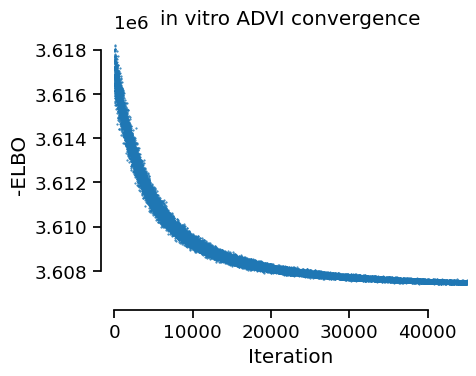

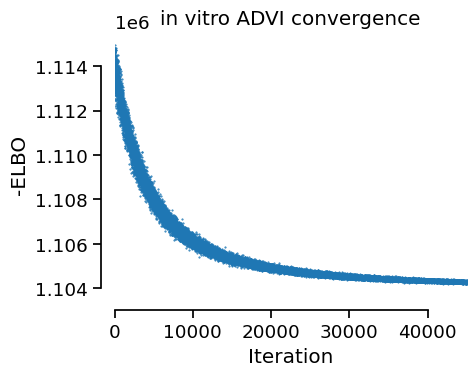

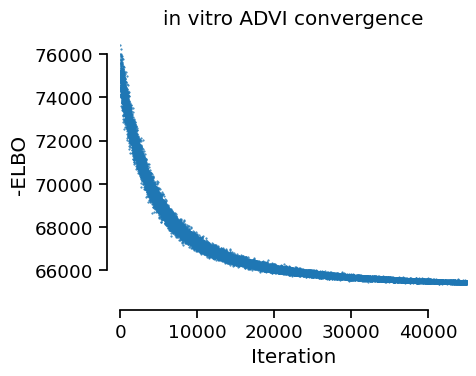

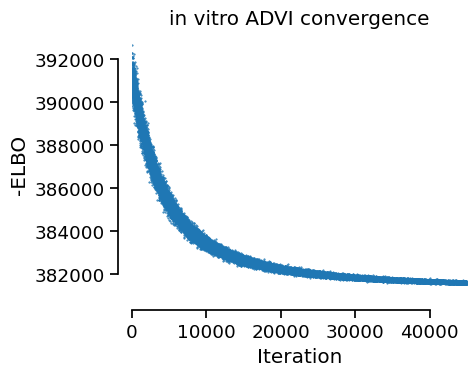

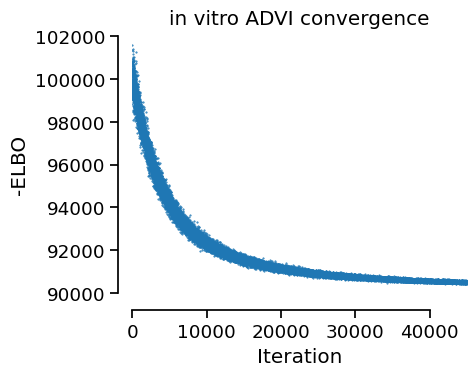

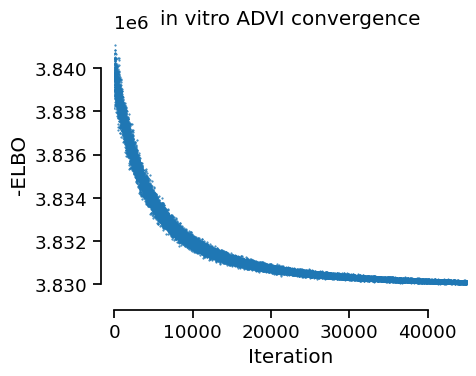

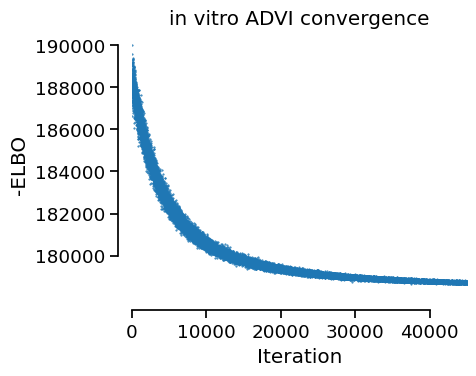

In [9]:
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)

trace05 = run_BayesInf(BMCA_obj05, n_samp=3)
trace10 = run_BayesInf(BMCA_obj10, n_samp=3)
trace15 = run_BayesInf(BMCA_obj15, n_samp=3)
trace3 = run_BayesInf(BMCA_obj3, n_samp=3)
trace5 = run_BayesInf(BMCA_obj5, n_samp=3)
trace7 = run_BayesInf(BMCA_obj7, n_samp=3)
trace100 = run_BayesInf(BMCA_obj100, n_samp=3)

## Plotting ADVI results

In [ ]:
import arviz as az
def get_az_mean(traces): 
    trace_means = []
    for t in traces: 
        Ex_mean = az.summary(t)['mean'].reset_index()
        Ex_mean.columns = ['elasticity', 'mean']
        Ex_mean = Ex_mean[Ex_mean.elasticity.str.contains("Ex\[")]['mean'].values.flatten().reshape((-1,1))
        trace_means.append(Ex_mean)
    Ex = np.concatenate(trace_means, axis=1)
    return np.mean(Ex, axis=1)

In [ ]:
med_Ex01_advi = get_az_mean(trace01)
med_Ex02_advi = get_az_mean(trace02)
med_Ex03_advi = get_az_mean(trace03)
med_Ex04_advi = get_az_mean(trace04)

med_Ex05_advi = get_az_mean(trace05)
med_Ex10_advi = get_az_mean(trace10)
med_Ex15_advi = get_az_mean(trace15)
med_Ex3_advi = get_az_mean(trace3)
med_Ex5_advi = get_az_mean(trace5)
med_Ex7_advi = get_az_mean(trace7)
med_Ex100_advi = get_az_mean(trace100)

In [10]:
vt01_0 = (trace01[0]['posterior']['v_t']).to_numpy().squeeze()
vt01_1 = (trace01[1]['posterior']['v_t']).to_numpy().squeeze()
vt01_2 = (trace01[2]['posterior']['v_t']).to_numpy().squeeze()
vt01 = np.concatenate([vt01_0, vt01_1, vt01_2])
med_vt_advi = np.median(vt01, axis=0).transpose()

vt02_0 = (trace02[0]['posterior']['v_t']).to_numpy().squeeze()
vt02_1 = (trace02[1]['posterior']['v_t']).to_numpy().squeeze()
vt02_2 = (trace02[2]['posterior']['v_t']).to_numpy().squeeze()
vt02 = np.concatenate([vt02_0, vt02_1, vt02_2])
med_vt_advi = np.median(vt02, axis=0).transpose()

vt03_0 = (trace03[0]['posterior']['v_t']).to_numpy().squeeze()
vt03_1 = (trace03[1]['posterior']['v_t']).to_numpy().squeeze()
vt03_2 = (trace03[2]['posterior']['v_t']).to_numpy().squeeze()
vt03 = np.concatenate([vt03_0, vt03_1, vt03_2])
med_vt_advi = np.median(vt03, axis=0).transpose()

vt04_0 = (trace04[0]['posterior']['v_t']).to_numpy().squeeze()
vt04_1 = (trace04[1]['posterior']['v_t']).to_numpy().squeeze()
vt04_2 = (trace04[2]['posterior']['v_t']).to_numpy().squeeze()
vt04 = np.concatenate([vt04_0, vt04_1, vt04_2])
med_vt_advi = np.median(vt04, axis=0).transpose()

vt05_0 = (trace05[0]['posterior']['v_t']).to_numpy().squeeze()
vt05_1 = (trace05[1]['posterior']['v_t']).to_numpy().squeeze()
vt05_2 = (trace05[2]['posterior']['v_t']).to_numpy().squeeze()
vt05 = np.concatenate([vt05_0, vt05_1, vt05_2])
med_vt_advi = np.median(vt05, axis=0).transpose()

vt10_0 = (trace10[0]['posterior']['v_t']).to_numpy().squeeze()
vt10_1 = (trace10[1]['posterior']['v_t']).to_numpy().squeeze()
vt10_2 = (trace10[2]['posterior']['v_t']).to_numpy().squeeze()
vt10 = np.concatenate([vt10_0, vt10_1, vt10_2])
med_vt_advi = np.median(vt10, axis=0).transpose()

vt15_0 = (trace15[0]['posterior']['v_t']).to_numpy().squeeze()
vt15_1 = (trace15[1]['posterior']['v_t']).to_numpy().squeeze()
vt15_2 = (trace15[2]['posterior']['v_t']).to_numpy().squeeze()
vt15 = np.concatenate([vt15_0, vt15_1, vt15_2])
med_vt_advi = np.median(vt15, axis=0).transpose()

vt3_0 = (trace3[0]['posterior']['v_t']).to_numpy().squeeze()
vt3_1 = (trace3[1]['posterior']['v_t']).to_numpy().squeeze()
vt3_2 = (trace3[2]['posterior']['v_t']).to_numpy().squeeze()
vt3 = np.concatenate([vt3_0, vt3_1, vt3_2])
med_vt_advi = np.median(vt3, axis=0).transpose()

vt5_0 = (trace5[0]['posterior']['v_t']).to_numpy().squeeze()
vt5_1 = (trace5[1]['posterior']['v_t']).to_numpy().squeeze()
vt5_2 = (trace5[2]['posterior']['v_t']).to_numpy().squeeze()
vt5 = np.concatenate([vt5_0, vt5_1, vt5_2])
med_vt_advi = np.median(vt5, axis=0).transpose()

vt7_0 = (trace7[0]['posterior']['v_t']).to_numpy().squeeze()
vt7_1 = (trace7[1]['posterior']['v_t']).to_numpy().squeeze()
vt7_2 = (trace7[2]['posterior']['v_t']).to_numpy().squeeze()
vt7 = np.concatenate([vt7_0, vt7_1, vt7_2])
med_vt_advi = np.median(vt7, axis=0).transpose()

vt100_0 = (trace100[0]['posterior']['v_t']).to_numpy().squeeze()
vt100_1 = (trace100[1]['posterior']['v_t']).to_numpy().squeeze()
vt100_2 = (trace100[2]['posterior']['v_t']).to_numpy().squeeze()
vt100 = np.concatenate([vt100_0, vt100_1, vt100_2])
med_vt_advi = np.median(vt100, axis=0).transpose()


## Calculating FCCs

In [12]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [13]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / med_vt_advi)# BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(3000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(3000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(3000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC


### Negative predictions

In [14]:
postFCC01 = estimate_CCs(BMCA_obj01, med_Ex01_advi.reshape((16,11)))
postFCC02 = estimate_CCs(BMCA_obj02, med_Ex02_advi.reshape((16,11)))
postFCC03 = estimate_CCs(BMCA_obj03, med_Ex03_advi.reshape((16,11)))
postFCC04 = estimate_CCs(BMCA_obj04, med_Ex04_advi.reshape((16,11)))

postFCC05 = estimate_CCs(BMCA_obj05, med_Ex05_advi.reshape((16,11)))
postFCC10 = estimate_CCs(BMCA_obj10, med_Ex10_advi.reshape((16,11)))
postFCC15 = estimate_CCs(BMCA_obj15, med_Ex15_advi.reshape((16,11)))
postFCC3 = estimate_CCs(BMCA_obj3, med_Ex3_advi.reshape((16,11)))
postFCC5 = estimate_CCs(BMCA_obj5, med_Ex5_advi.reshape((16,11)))
postFCC7 = estimate_CCs(BMCA_obj7, med_Ex7_advi.reshape((16,11)))
postFCC100 = estimate_CCs(BMCA_obj100, med_Ex100_advi.reshape((16,11)))

In [15]:
rxn_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [16]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [17]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.5x,-1.819427,-0.019851,-0.002607,-0.026648,0.002873,-0.013700,0.000246,0.003607,0.009409,-0.007625,0.007123,0.006652,0.004795,0.831505,0.012219,0.007714
vPGI,0.5x,0.007115,-1.988779,-0.001599,-0.016347,-0.000784,-0.020665,0.026232,0.010862,0.049307,-0.066436,0.090461,0.107189,0.094828,0.018114,0.241655,0.126793
vGLYCO,0.5x,-0.176150,0.231881,-0.887581,1.149176,-0.029980,0.075771,0.046596,-0.041647,-0.055075,0.022164,0.007967,-0.009530,-0.007948,-1.564620,-0.020255,-0.003020
vTreha,0.5x,0.302966,-0.091217,-0.113612,-2.161365,0.010979,-0.026068,-0.028308,0.002357,-0.000809,0.019305,-0.031110,-0.032445,-0.026046,1.547953,-0.066375,-0.043102
vPFK,0.5x,0.007115,0.011221,-0.001599,-0.016347,-2.000784,-0.020665,0.026232,0.010862,0.049307,-0.066436,0.090461,0.107189,0.094828,0.018114,0.241655,0.126793


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_23448\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

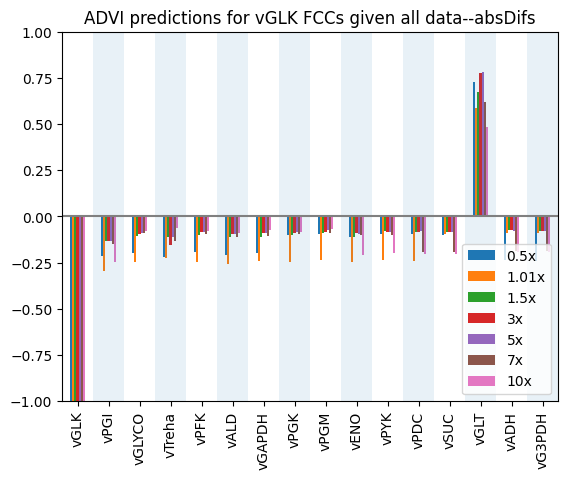

<Figure size 1600x1000 with 0 Axes>

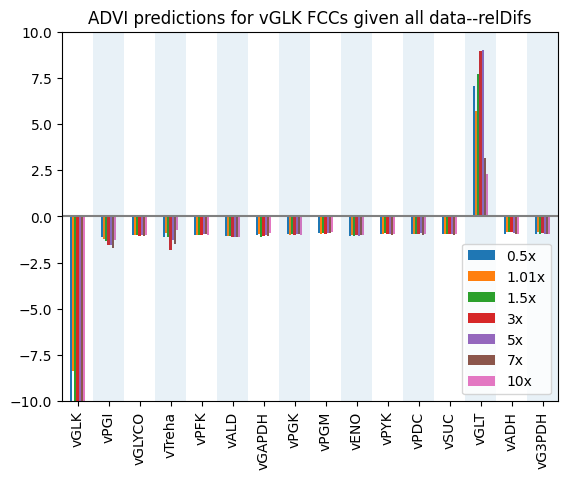

<Figure size 1600x1000 with 0 Axes>

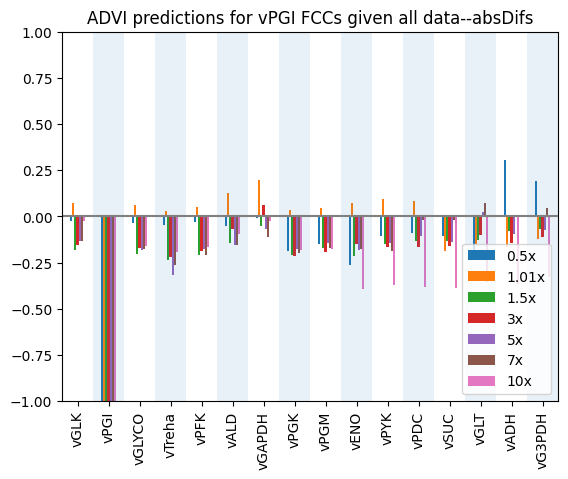

<Figure size 1600x1000 with 0 Axes>

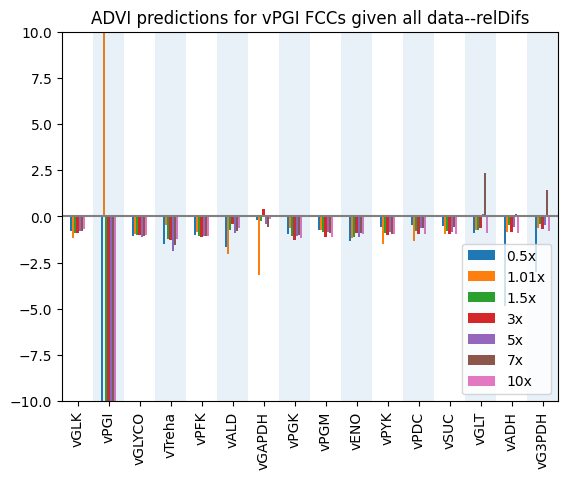

<Figure size 1600x1000 with 0 Axes>

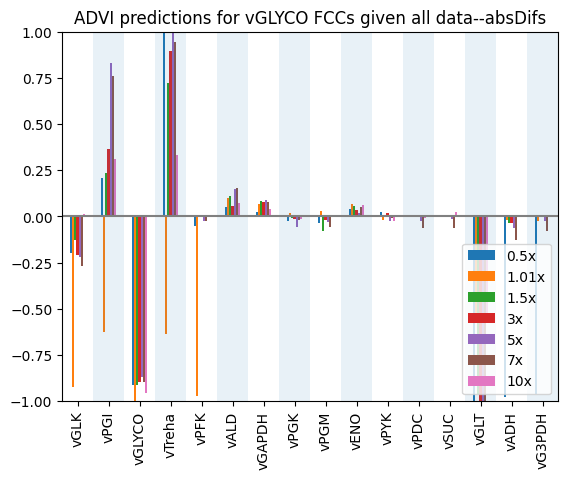

<Figure size 1600x1000 with 0 Axes>

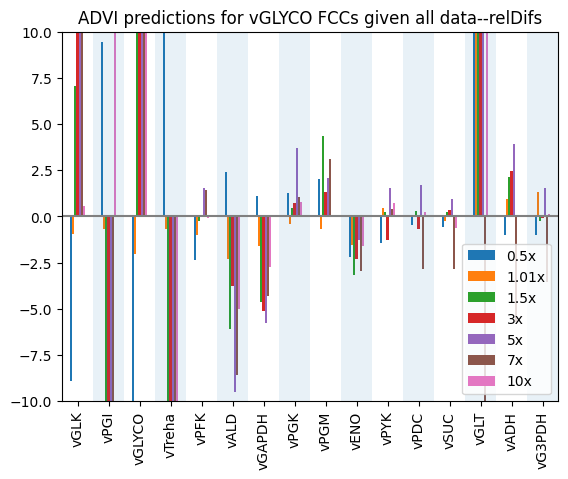

<Figure size 1600x1000 with 0 Axes>

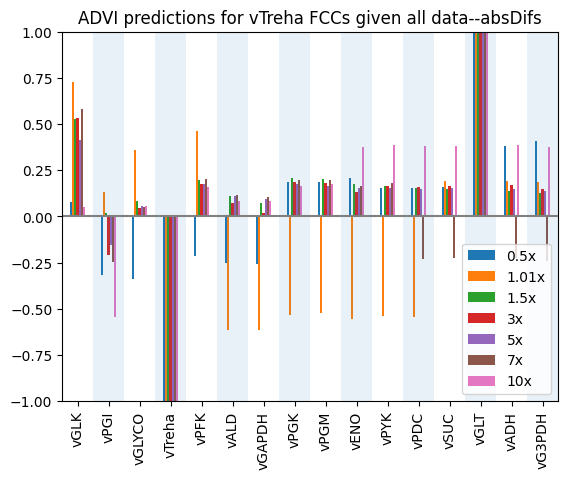

<Figure size 1600x1000 with 0 Axes>

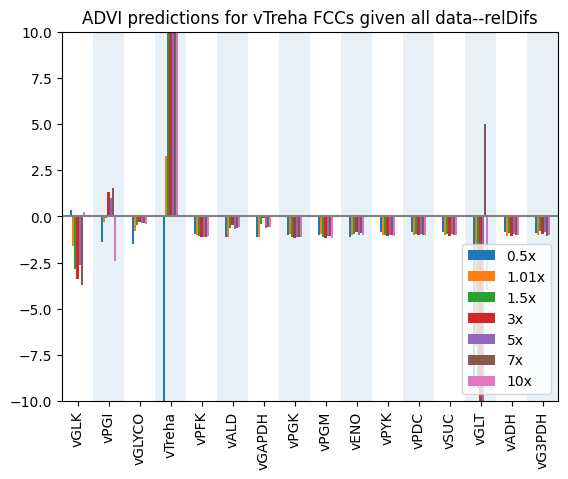

<Figure size 1600x1000 with 0 Axes>

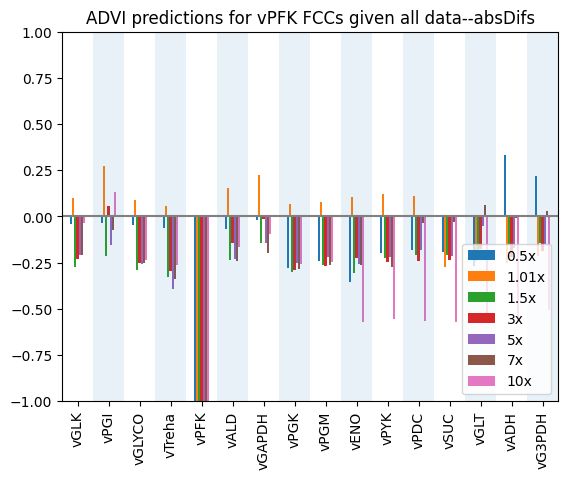

<Figure size 1600x1000 with 0 Axes>

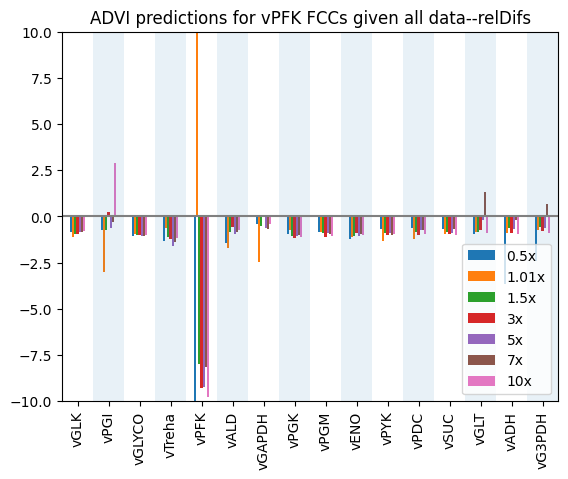

<Figure size 1600x1000 with 0 Axes>

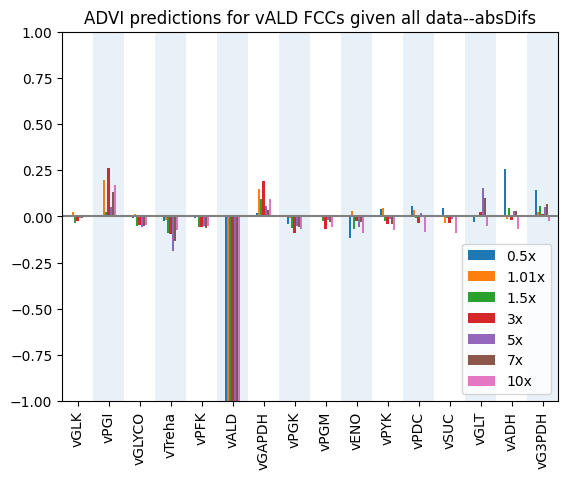

<Figure size 1600x1000 with 0 Axes>

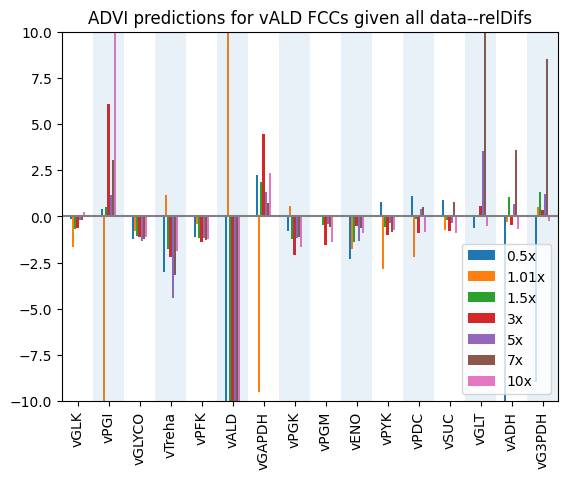

<Figure size 1600x1000 with 0 Axes>

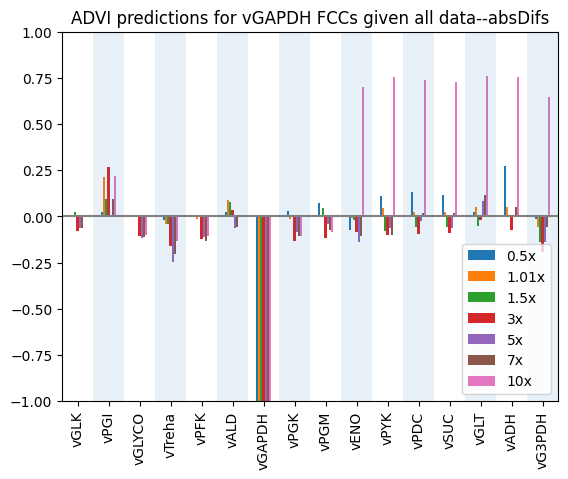

<Figure size 1600x1000 with 0 Axes>

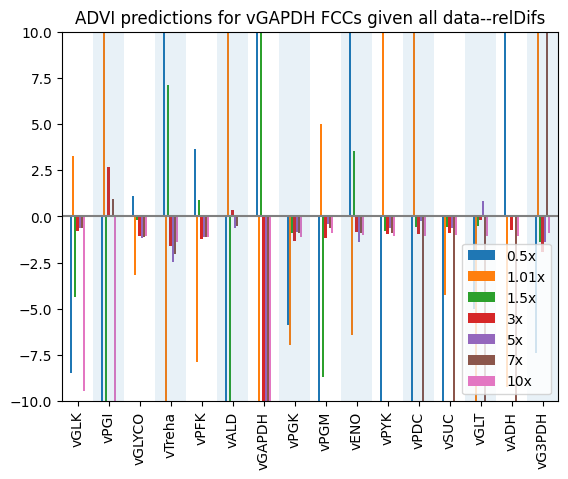

<Figure size 1600x1000 with 0 Axes>

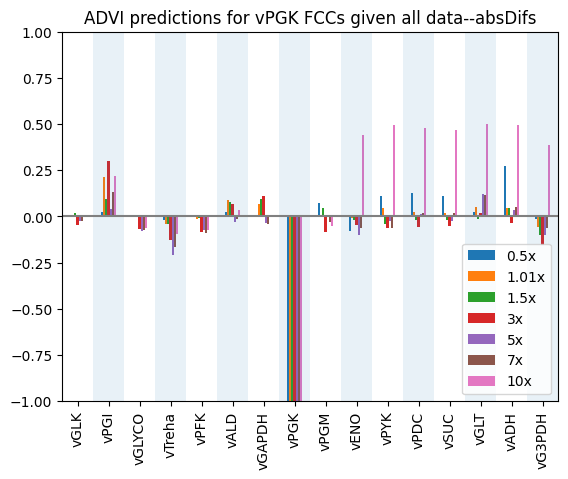

<Figure size 1600x1000 with 0 Axes>

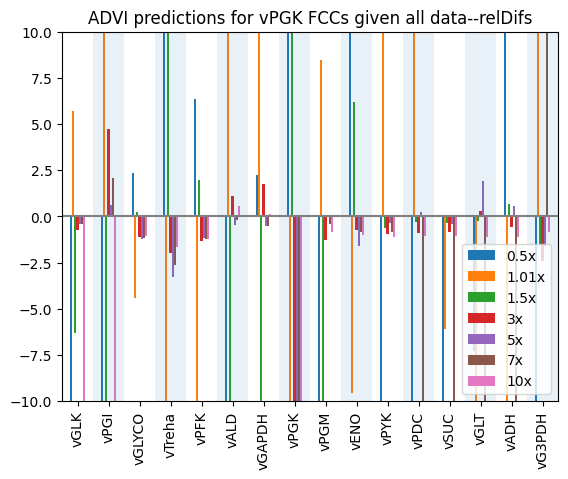

<Figure size 1600x1000 with 0 Axes>

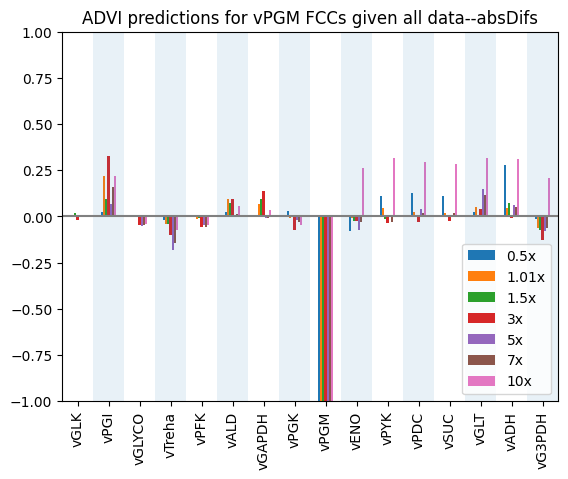

<Figure size 1600x1000 with 0 Axes>

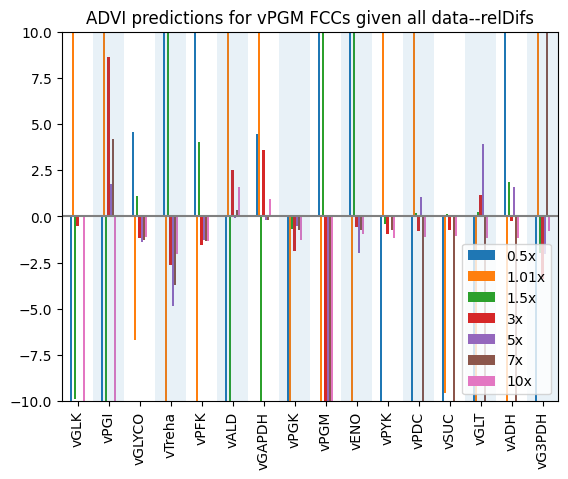

<Figure size 1600x1000 with 0 Axes>

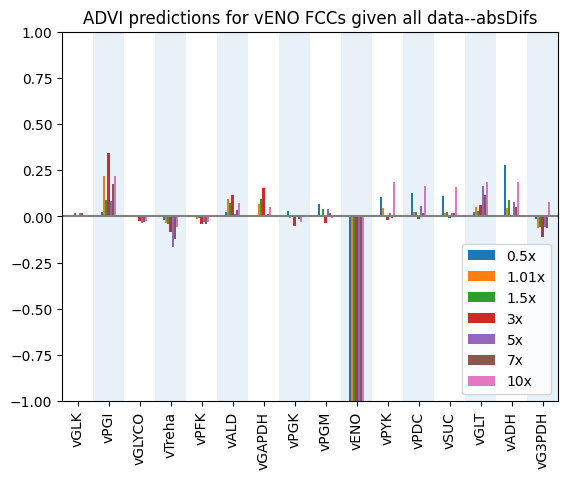

<Figure size 1600x1000 with 0 Axes>

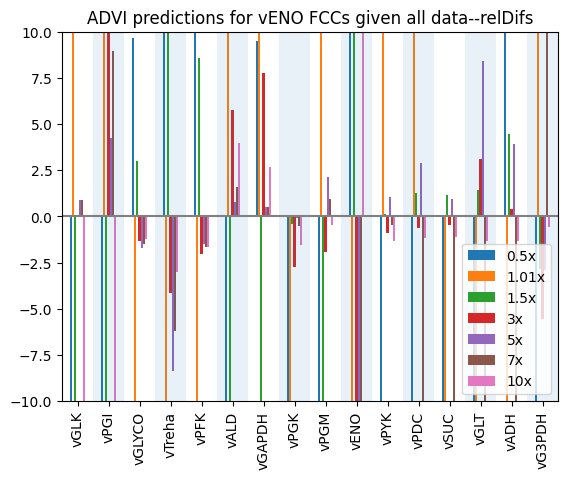

<Figure size 1600x1000 with 0 Axes>

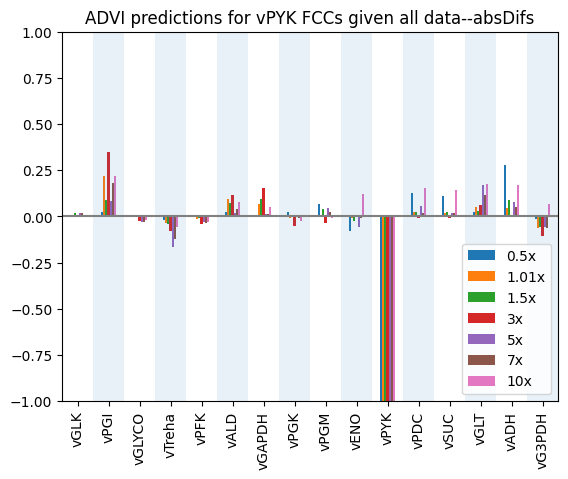

<Figure size 1600x1000 with 0 Axes>

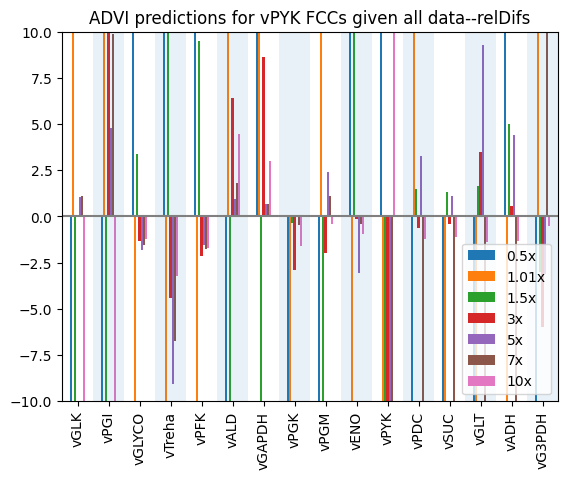

<Figure size 1600x1000 with 0 Axes>

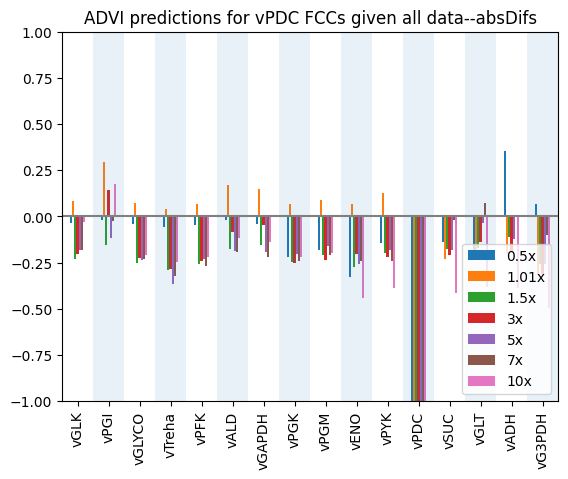

<Figure size 1600x1000 with 0 Axes>

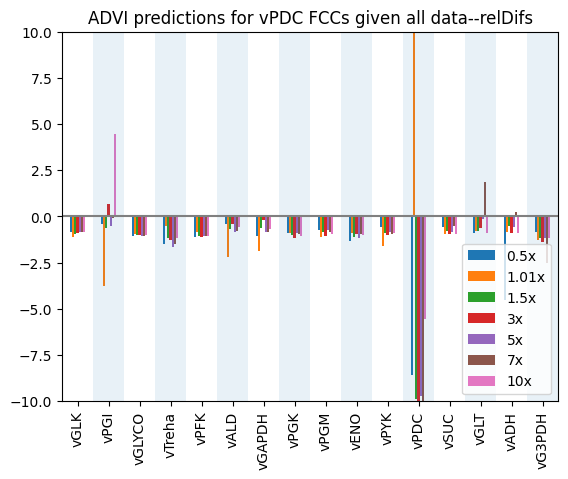

<Figure size 1600x1000 with 0 Axes>

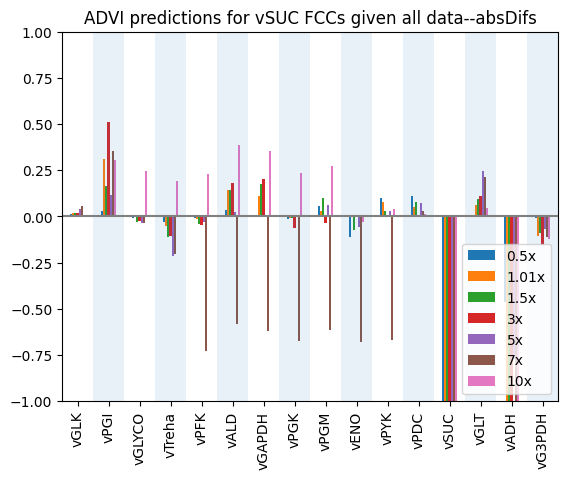

<Figure size 1600x1000 with 0 Axes>

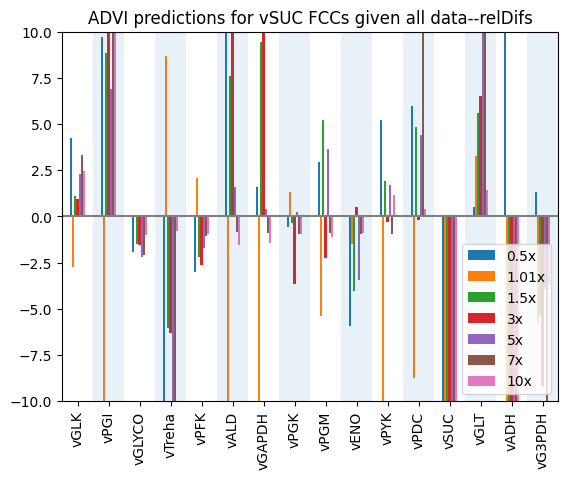

<Figure size 1600x1000 with 0 Axes>

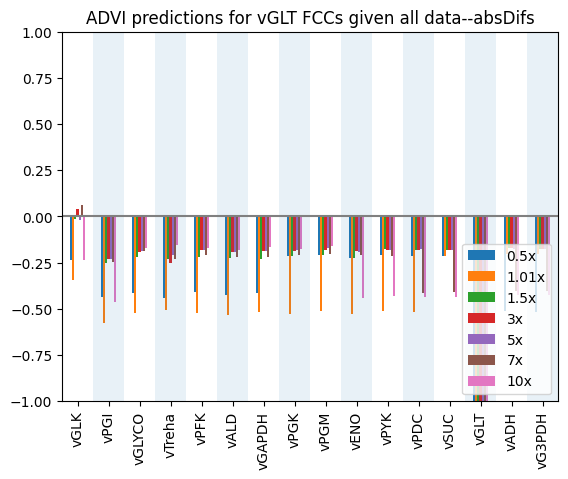

<Figure size 1600x1000 with 0 Axes>

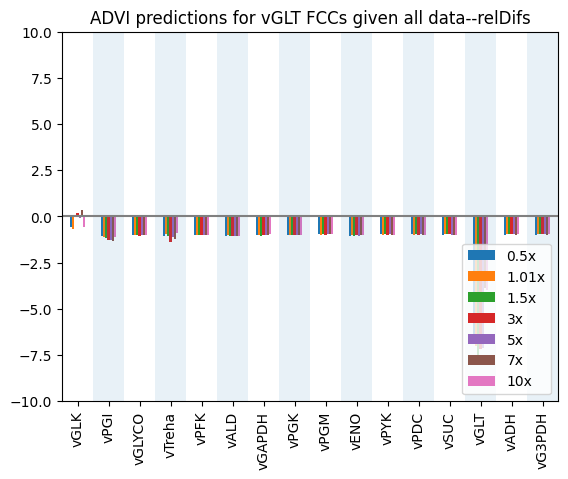

<Figure size 1600x1000 with 0 Axes>

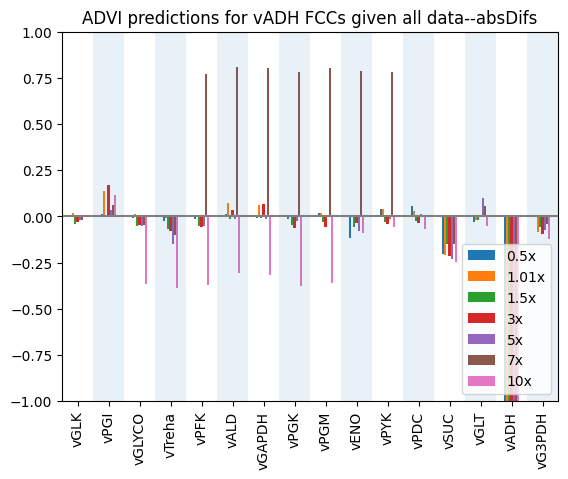

<Figure size 1600x1000 with 0 Axes>

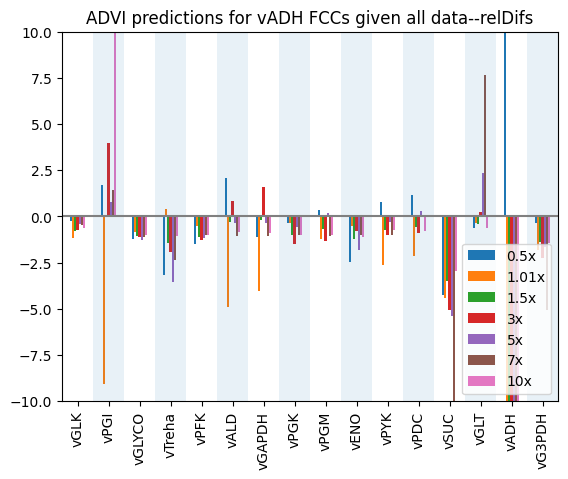

<Figure size 1600x1000 with 0 Axes>

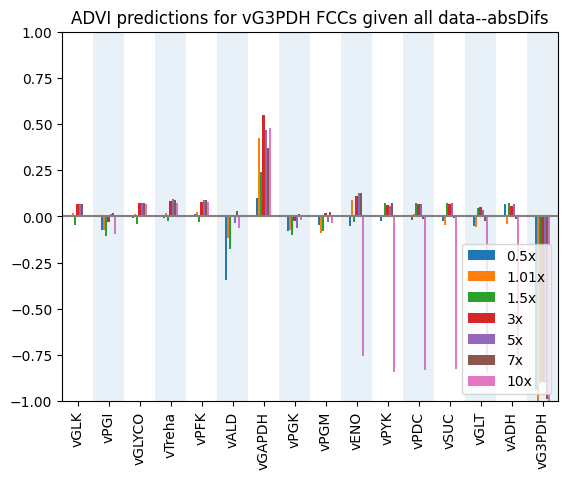

<Figure size 1600x1000 with 0 Axes>

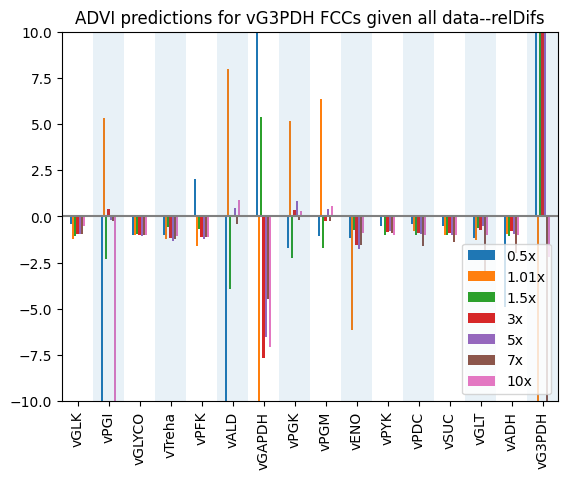

In [18]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    """
    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')
    """

In [19]:
plt.close("all")

## Evaluating FCC ranking

In [20]:
## ground truth FCC rankings

gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vADH']

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
vGLK,NaN,5.0,6.0,2.0,3.0,7.0,11.0,12.0,13.0,14.0,15.0,4.0,10.0,1.0,8.0,9.0
vPGI,5.0,NaN,10.0,4.0,1.0,6.0,11.0,12.0,13.0,14.0,15.0,2.0,9.0,3.0,7.0,8.0
vGLYCO,3.0,6.0,NaN,2.0,4.0,7.0,11.0,12.0,13.0,14.0,15.0,5.0,10.0,1.0,8.0,9.0
vTreha,2.0,5.0,6.0,NaN,3.0,7.0,11.0,12.0,13.0,14.0,15.0,4.0,10.0,1.0,8.0,9.0
vPFK,5.0,3.0,10.0,4.0,NaN,6.0,11.0,12.0,13.0,14.0,15.0,1.0,9.0,2.0,7.0,8.0
vALD,6.0,4.0,10.0,5.0,1.0,NaN,11.0,12.0,13.0,14.0,15.0,2.0,9.0,3.0,7.0,8.0
vGAPDH,6.0,4.0,15.0,5.0,1.0,9.0,NaN,8.0,11.0,12.0,13.0,2.0,14.0,3.0,10.0,7.0
vPGK,7.0,4.0,15.0,5.0,1.0,9.0,6.0,NaN,11.0,12.0,13.0,2.0,14.0,3.0,10.0,8.0
vPGM,7.0,4.0,15.0,5.0,1.0,10.0,6.0,9.0,NaN,12.0,13.0,2.0,14.0,3.0,11.0,8.0
vENO,7.0,4.0,15.0,5.0,1.0,10.0,6.0,9.0,12.0,NaN,13.0,2.0,14.0,3.0,11.0,8.0


### via Spearman rank coefficients

In [ ]:
def calculate_FCC_med_rankings(postFCC, reaction='vADH'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

In [21]:
spearman_coefficients = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_coefficients.append(stats.spearmanr(a.dropna().values, b.dropna().values))

In [ ]:
spearman_coefficients

In [22]:
plt.plot(pt_labels, [i[0] for i in spearman_coefficients],'ro')

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]))

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')


### evaluating top five rankings

In [ ]:
ranked_b_list = [b.sort_values().reset_index().set_index('vADH') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vADH')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q

In [24]:
q.to_csv('omitFluxes_simplTeusink_reg1_rankings.csv')

0.5x     11
1.01x    12
1.5x      3
3x       15
5x       16
7x       22
10x       5
dtype: int64